In [1]:
using SLMTools
using Distributions, Plots, Images, FFTW, JLD2, LinearAlgebra, FileIO
using SLMTools: wrap

In [2]:
function pdError(divs::NTuple{M,LF{Intensity,<:Number,N}},divPhases::NTuple{M,LF{<:Phase,<:Number,N}},beamGuess::LF{ComplexAmp,<:Complex,N}) where {M,N}
    [elq(d,beamGuess) for d in divPhases], [ldq(m,beamGuess) for m in divs]
    divs = Tuple(normalizeLF(m) for m in divs)
    reconstructions = Tuple(normalizeLF(square(sft(beamGuess*p))) for p in divPhases)
    return sqrt(sum(sum((divs[i].data - reconstructions[i].data).^2) for i=1:M) / M)
end

function pdError(divMods::NTuple{M,LF{Modulus,<:Number,N}},divPhases::NTuple{M,LF{<:Phase,<:Number,N}},beamGuess::LF{ComplexAmp,<:Complex,N}) where {M,N}
    return pdError(Tuple(square(d) for d in divMods),divPhases,beamGuess)
end

function pdgsLog4(imgs::NTuple{M,LF{Modulus,<:Number,N}},divPhases::NTuple{M,LF{<:Phase,<:Number,N}},nit::Integer,beamGuess::LF{ComplexAmp,<:Complex,N},
        comparisonPhases::NTuple{Q,LF{<:Phase,<:Number,N}}, comparisonDivs::NTuple{Q,LF{Modulus,<:Number,N}}; every::Int=1) where {M,N,Q}
    s = size(imgs[1])
    all(size(i)==s for i in imgs) && all(size(i)==size(beamGuess) for i in divPhases) || error("Input size mismatch.")
    [elq(d,beamGuess) for d in divPhases], [ldq(i,beamGuess) for i in imgs]

    guess = beamGuess
    phis = Tuple(wrap(divPhases[i]) * dualPhase(imgs[i].L,imgs[i].flambda) for i=1:M)
    comparisonPhis = Tuple(wrap(comparisonPhases[i]) * dualPhase(comparisonDivs[i].L,comparisonDivs[i].flambda) for i=1:Q)
    mods = imgs
    errs = []
    for j=1:nit
        updates = Tuple(isft(mods[i] * phasor(sft(guess * phis[i]))) * conj(phis[i]) for i = 1:M)
        guess = +(updates...) / M
        if (j-1)%every == 0 
            err = pdError(comparisonDivs,comparisonPhis,guess)
            push!(errs,err)
        end
    end
    return guess, errs
end

function pdgsLog4(imgs::NTuple{M,LF{Intensity,<:Number,N}},divPhases::NTuple{M,LF{<:Phase,<:Number,N}},nit::Integer,beamGuess::LF{ComplexAmp,<:Complex,N},
        comparisonPhases::NTuple{Q,LF{<:Phase,<:Number,N}}, comparisonDivs::NTuple{Q,LF{Intensity,<:Number,N}}; every::Int=1) where {M,N,Q}
    pdgsLog4(Tuple(sqrt(i) for i in imgs),divPhases,nit,beamGuess,comparisonPhases,Tuple(sqrt(i) for i in comparisonDivs); every=every)
end

function poissonify(div::LF{Intensity},bits=16)
    d = LF{Intensity}(div.data * ((2^bits - 1) / maximum(div.data)),div.L,div.flambda)
    n = LF{Intensity}([convert.(Float64,rand(Poisson(d.data[I]))) for I in CartesianIndices(size(d))],div.L,div.flambda)
    return normalizeLF(n)
end

poissonify (generic function with 2 methods)

In [3]:
N = 128;
L0 = natlat((N,N));

In [4]:
# Execute this cell to produce a new random input beam
q = 1
a = 0.25
randAmp(n,m) = n==m==0 ? 1 : a*(randn() + im*randn())/(n^2+m^2)^q
nmas = Tuple((n,m,randAmp(n,m)) for n=0:20,m=0:20)
g = LF{ComplexAmp}(multimodeBeam(nmas,L0,0,1.5,1),L0)
look(g)

LoadError: UndefVarError: `multimodeBeam` not defined

┌ Warning: saved type Tuple{Tuple{Int64, Int64, Int64}, Vararg{Tuple{Int64, Int64, ComplexF64}, 440}} is missing field 186 in workspace type; reconstructing
└ @ JLD2 C:\Users\stron\.julia\packages\JLD2\VWinU\src\data\reconstructing_datatypes.jl:207


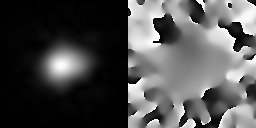

In [5]:
# Execute this cell to use the input beam of the paper (generated from the above cell)
gdict = load_object("beam-ground-truth-2024-1-15.jld2")
g = gdict[:lfbeam]
nmas = gdict[:amplitudes]
look(g)

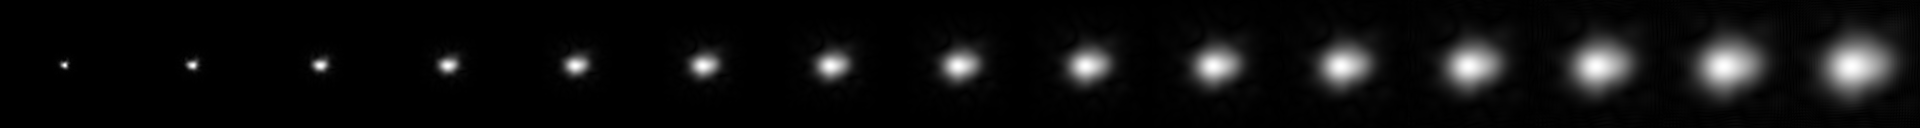

In [6]:
alphas = 0.1:0.1:1.5
phis = Tuple(LF{RealPhase}(α*r2(L0)/2,L0) for α in alphas)
divs = Tuple(sft(g * phi)|>abs for phi in phis)
look(divs...)

0.021418830406351258
0.005096527971239356
3.086881938684599e-17


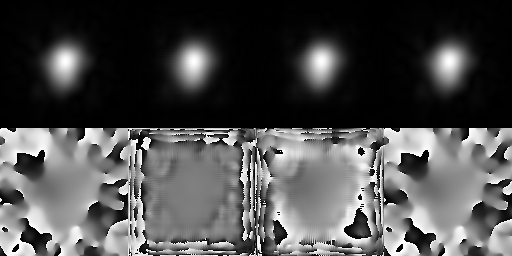

In [7]:
# Perform beam estimation with one-shot, two-shot, and IFT methods
g_oneshot1 = oneShot(square(divs[end]),alphas[end],(0.0,0.0));
g_ot1 = pdotBeamEstimate(square(divs[end]),square(divs[1]), alphas[end],alphas[1], [0,0], [0,0], 0.001);
g_ift1 = pdgs(square.(divs[[1,7,15]]), phis[[1,7,15]], 1000, g_ot1);

println(pdError(divs,phis,g_oneshot1))
println(pdError(divs,phis,g_ot1))
println(pdError(divs,phis,g_ift1))

phaseNormalize(x) = x * conj(x[(size(x) .÷ 2)...])
hcat(transpose.(look.(phaseNormalize.([g, g_oneshot1, g_ot1, g_ift1])))...)

Error plots

In [8]:
ssets = [[1,15],[1,8,15],[1,6,10,15],[1,4,7,9,12,15],[1:15...]]
noiselessErrs = zeros(Float64,1000,5)
tmp = lfRand(g)
for i in 1:length(ssets)
    s = ssets[i]
    noiselessErrs[:,i] = pdgsLog4(divs[s],phis[s],1000,tmp,phis,divs)[2]
    println("Done with "*string(i))
end

Done with 1
Done with 2
Done with 3
Done with 4
Done with 5


In [9]:
additiveErrs = zeros(Float64,1000,5);
η = 2^(-15)
noisyDivs = Tuple(sqrt(d/maximum(d.data) + η*lfRand(d)) for d in square.(divs))
noiselessDivs = Tuple(normalizeLF(d) for d in divs)
tmp = lfRand(g)
for i=1:5
    sset = ssets[i]
    additiveErrs[:,i] = pdgsLog4(noisyDivs[sset],phis[sset],1000,tmp,phis,divs)[2]
    println("Done with "*string(i))
end

Done with 1
Done with 2
Done with 3
Done with 4
Done with 5


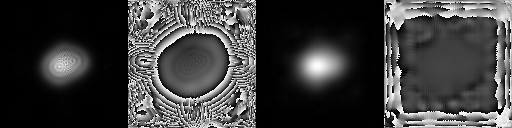

In [10]:
g_ot_n1 = pdotBeamEstimate(square(noisyDivs[end]),square(noisyDivs[1]), alphas[end],alphas[1], [0,0], [0,0], 0.001);
g_oneshot_n1 = oneShot(square(noisyDivs[end]), alphas[end],(0.0,0.0));
look(g_ot_n1,g_oneshot_n1)

In [11]:
bits = 16
poissonDivs = Tuple(sqrt(poissonify(d, bits)) for d in square.(divs))
poissonErrs = zeros(Float64,1000,5);
tmp = lfRand(g)
for i=1:5
    sset = ssets[i]
    poissonErrs[:,i] = pdgsLog4(poissonDivs[sset],phis[sset],1000,tmp,phis,divs)[2]
    println("Done with "*string(i))
end

Done with 1
Done with 2
Done with 3
Done with 4
Done with 5


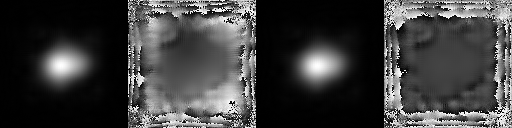

In [12]:
g_ot_p1 = pdotBeamEstimate(square(poissonDivs[end]),square(poissonDivs[1]), alphas[end],alphas[1], [0,0], [0,0], 0.001);
g_oneshot_p1 = oneShot(square(poissonDivs[end]), alphas[end],(0.0,0.0));
look(g_ot_p1,g_oneshot_p1)

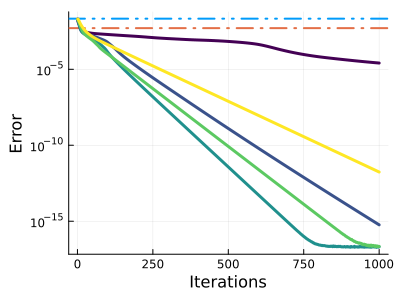

In [13]:
p1 = plot()
hline!([pdError(divs,phis,g_oneshot1)],linestyle=:dashdotdot,label="1-shot",linewidth=2)
hline!([pdError(divs,phis,g_ot1)],linestyle=:dashdot,label="2-shot",linewidth=2)
plot!(noiselessErrs,yaxis=:log,linewidth=3,color=:viridis, line_z=(0:5)',legend=false,legendfontsize=10,colorbar=false,xlabel="Iterations",ylabel="Error",size=(400,300),labels=["n=2" "n=3" "n=4" "n=6" "n=15"])


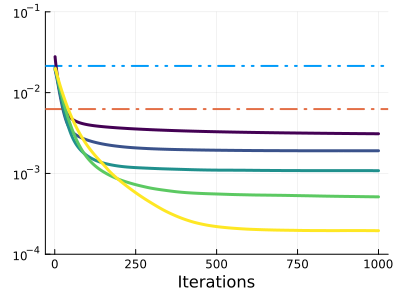

In [14]:
p2 = plot()
hline!([pdError(divs,phis,g_oneshot_n1)],linestyle=:dashdotdot,label="1-shot",linewidth=2)
hline!([pdError(divs,phis,g_ot_n1)],linestyle=:dashdot,label="2-shot",linewidth=2)
plot!(additiveErrs,yaxis=:log,linewidth=3,color=:viridis, line_z=(0:5)',legend=false,legendfontsize=10,colorbar=false,
    xlabel="Iterations",size=(400,300),labels=["n=2" "n=3" "n=4" "n=6" "n=15"],ylim=(1e-4,1e-1))


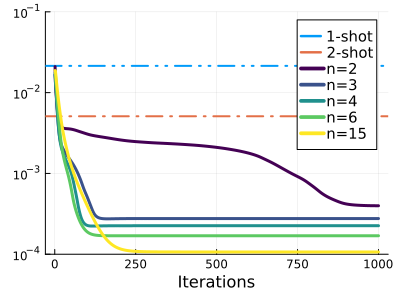

In [15]:
p3 = plot()
hline!([pdError(noiselessDivs,phis,g_oneshot_p1)],linestyle=:dashdotdot,label="1-shot",linewidth=2)
hline!([pdError(noiselessDivs,phis,g_ot_p1)],linestyle=:dashdot,label="2-shot",linewidth=2)
plot!(poissonErrs,yaxis=:log,linewidth=3,color=:viridis, line_z=(0:5)',legend=:topright,legendfontsize=10,colorbar=false,
    xlabel="Iterations",size=(400,300),labels=["n=2" "n=3" "n=4" "n=6" "n=15"],ylim=(1e-4,1e-1))


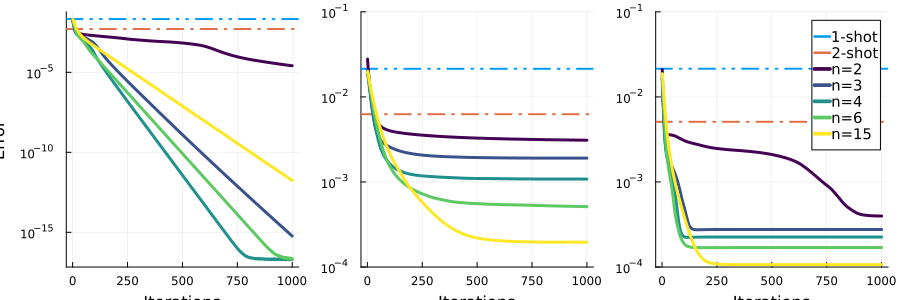

In [16]:
plotParams = Dict(
    #:ann => (:bottomleft,:auto),
    #:annotationcolor => :black,
    :size => (900,300),
    :layout => grid(1,3),
    #left_margin = (0.0,:mm),
    #:grid => false
    )

plot(p1,p2,p3;plotParams...)

In [17]:
#savefig("pd-convergence-merged-2024-6-30.png")

In [18]:
#savefig("pd-convergence-merged-2024-6-30.pdf")